In [3]:
!pip3 install torch

  Using cached torch-1.12.0-cp38-cp38-manylinux1_x86_64.whl (776.3 MB)
ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device: '/tmp/pip-unpacked-wheel-dxjhi82q/torch/lib/libtorch_cuda.so' -> '/home/admin/ClipModel/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so'



In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F

from datasets import load_dataset

from torch.utils.data import Dataset, DataLoader
from functools import partial

from tqdm.auto import tqdm

import numpy as np

import pickle as pkl

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

In [5]:
seed = 0xAB0BA
torch.manual_seed(seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
# dataset = load_dataset("dalle-mini/YFCC100M_OpenAI_subset", keep_in_memory=False, split='validation')

In [7]:
# https://huggingface.co/datasets/daily_dialog
daily_dialog_dataset = load_dataset("daily_dialog")

Using custom data configuration default
Reusing dataset daily_dialog (/home/admin/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
train_dialog_data = daily_dialog_dataset['train']['dialog']
train_dialog_data[0]

['Say , Jim , how about going for a few beers after dinner ? ',
 ' You know that is tempting but is really not good for our fitness . ',
 ' What do you mean ? It will help us to relax . ',
 " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ",
 " I guess you are right.But what shall we do ? I don't feel like sitting at home . ",
 ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ',
 " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ",
 ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ',
 " Good.Let ' s go now . ",
 ' All right . ']

In [9]:
dummy_dialog_data = [
    'sunny landscape', 'cloudy beach', 'a ball and a girl',
    'hello girl', 'goodbye dad', 'in four hours'
]

In [10]:
class DialogDataset(Dataset):
    def __init__(self, dialogs, tokenizer, min_length=0, max_length=np.inf):
        self.dialogs = dialogs
        self.texts = []
        self.tokenizer = tokenizer
        self.tokens = []
        for dialog in tqdm(dialogs):
            for text in dialog:
                n_words = len(list(filter(lambda x: len(x) > 2, text.split())))
                if min_length <= n_words <= max_length:
                    tokens = self.tokenizer.encode(text, return_tensors='pt').squeeze(0)
                    self.tokens.append(tokens)
                    self.texts.append(text)
    
    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'tokens': self.tokens[idx], 'tokens_len': len(self.tokens[idx])}
        
    def __len__(self):
        return len(self.texts)


def collate_fn(batch, padding_value, pattern=None, is_postfix=False, batch_first=True):
    texts = [data['text'] for data in batch]
    if pattern is not None:
        if is_postfix:
            tokens = [torch.cat([data['tokens'][:-1], pattern]) for data in batch]
            tokens_lens = torch.tensor([data['tokens_len']-1 for data in batch], dtype=torch.long)
    
        else:
            tokens = [torch.cat([pattern, data['tokens']]) for data in batch]
            tokens_lens = torch.tensor([data['tokens_len'] for data in batch], dtype=torch.long)
    else:
        tokens = [data['tokens'] for data in batch]
        tokens_lens = torch.tensor([data['tokens_len'] for data in batch], dtype=torch.long)
    
    tokens = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=batch_first,
                                             padding_value=padding_value)
    if is_postfix:
        start_idx = tokens_lens
        end_idx = start_idx + len(pattern)
    else:
        start_idx = torch.tensor([len(pattern) for data in batch], dtype=torch.long)
        end_idx = start_idx + tokens_lens
    
    return {'texts': texts, 'tokens': tokens, 'tokens_lens': tokens_lens, 'start_idx': start_idx, 'end_idx': end_idx}

In [11]:
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
train_dialog_dataset = DialogDataset(
    train_dialog_data, tokenizer=tokenizer,
    min_length=5, max_length=15
)

NameError: name 'AutoTokenizer' is not defined

In [8]:
train_dialog_dataset[0]

{'text': 'Say , Jim , how about going for a few beers after dinner ? ',
 'tokens': tensor([25515,   837,  5395,   837,   703,   546,  1016,   329,   257,  1178,
         16800,   706,  8073,  5633,   220]),
 'tokens_len': 15}

In [9]:
# model = GPT2LMHeadModel.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [13]:
def evaluate_confidence(model, dataset, pattern=None, is_postfix=False):
    pattern_tokens = tokenizer.encode(pattern, return_tensors='pt').squeeze(0)
    dataloader = DataLoader(
        dataset, batch_size=16,
        collate_fn=partial(collate_fn, padding_value=tokenizer.eos_token_id,
                           pattern=pattern_tokens, is_postfix=is_postfix)
    )
    conf_text_pairs = []
    model.eval()
    device = 'cuda:0'if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            tokens = batch['tokens'].to(device)
            texts = batch['texts']
            start_idx = batch['start_idx'].to(device)
            end_idx = batch['end_idx'].to(device)

            # mask, texts = get_len_mask(texts, 5, 30)
            # tokens = tokens[mask]

            outputs = model(tokens, labels=tokens)
            
            log_proba = F.log_softmax(outputs.logits, dim=-1)
            # print(log_proba.shape)
            true_proba = log_proba[torch.arange(log_proba.shape[0]).unsqueeze(-1),
                                   torch.arange(log_proba.shape[1]).unsqueeze(0),
                                   tokens]
            # print(true_proba.shape)
            # print(tokens.shape)
            for tp, start, end, text, t in zip(true_proba, start_idx, end_idx, texts, tokens):
                confidence = tp[start:end].mean().item()
                data = {'text': text, 'start_idx': start, 'end_idx': end, 'tokens': t}
                conf_text_pairs.append((confidence, data))

        return sorted(conf_text_pairs, reverse=True, key=lambda x: x[0])


In [17]:
# prefix = 'One this picture we can clearly see that'
# prefix = 'What is shown in the picture? On this picutre we can clearly see a small brown house. What is shown in the picture? On this picutre we can clearly see'
prefix = 'Whats on this picture?'
# prefix = 'Picture shows'
conf_text_pairs = evaluate_confidence(model, train_dialog_dataset, pattern=prefix)
# postfix = 'is clearly seen on this picture'
# conf_text_pairs = evaluate_confidence(model, train_dialog_dataset, pattern=postfix, is_postfix=True)


  0%|          | 0/3293 [00:00<?, ?it/s]

In [18]:
print(tokenizer.decode(conf_text_pairs[0][1]['tokens']))
[(conf, data['text']) for conf, data in conf_text_pairs[:50]]

Whats on this picture? Oh, that's my great, great, great, great, great, great, great grandfather. <|endoftext|><|endoftext|>


[(-6.414142608642578,
  " Oh , that's my great , great , great , great , great , great , great grandfather . "),
 (-6.465014934539795, 'Look ! Allen has the mic ! '),
 (-6.626712322235107,
  ' No , no ! Stupid machine , what are you doing ! No ! '),
 (-6.655226707458496, ' Bye bye ! Have a pleasant journey ! '),
 (-6.674813270568848, 'Hey honey ! Where were you ? '),
 (-6.67767858505249, ' 2 towels and l Turkish towel , please ? '),
 (-6.681142330169678, ' 456 Cherry Drive , Pasadena , CA 91170 . '),
 (-6.685594081878662, ' Sir , wait ! ! I need your address ! '),
 (-6.713062286376953,
  ' Hello . I have a reservation , under the name Lee , Leo Lee . '),
 (-6.721603870391846, ' Health insurance company and policy number ? '),
 (-6.7333269119262695, ' Apple , banana and strawberry pie . '),
 (-6.750104904174805, 'What is that plastic cup for ? '),
 (-6.773682594299316, ' Thirty meters ahead is the Waterloo Bridge . '),
 (-6.779448509216309,
  ' Phew ! . . . Wait a minute , CRASH ? ? ! !

In [ ]:
prefix = 'Whats on this picture?'
# prefix = 'What is shown in the picture? On this picutre we can clearly see a small brown house. What is shown in the picture? On this picutre we can clearly see'
dummy_data = [[
    'A beautiful castle', "Hey, dad, let's go home", 'A ball and a girl on it',
    'Teacher is a honorable job', 'A river in a field', 'We will meet in four hours'
]]
# dummy_data = [["that's a picture of me on our fourth day of travelling", "hi i work at school"]]
dummy_dataset = DialogDataset(dummy_data, tokenizer=tokenizer)
conf_text_pairs = evaluate_confidence(model, dummy_dataset, pattern=prefix, is_postfix=False)
[(pair[0], pair[1]['text']) for pair in conf_text_pairs]

In [ ]:
# !git clone https://github.com/VityaVitalich/NLPunks.git

fatal: destination path 'NLPunks' already exists and is not an empty directory.


In [15]:
# loop over all prefixes and find top-n sent for each
n = 100
with open('../NLPunks/prefix.txt') as prefix_file:
    prefix_list = [line.strip() for line in prefix_file]
    prefix_conf_topn_list = []
    for prefix in prefix_list:
        prefix_conf_topn_list.append(evaluate_confidence(model, train_dialog_dataset, pattern=prefix, is_postfix=False)[:n])

with open('prefix_conf_topn_list.pkl', 'wb') as output_file:
    pkl.dump(prefix_conf_topn_list, output_file)

In [16]:
n = 100
with open('../NLPunks/postfix.txt') as postfix_file:
    postfix_list = [line.strip() for line in postfix_file]
    postfix_conf_topn_list = []
    for postfix in postfix_list:
        postfix_conf_topn_list.append(evaluate_confidence(model, train_dialog_dataset, pattern=postfix, is_postfix=True)[:n])


with open('postfix_conf_topn_list.pkl', 'wb') as output_file:
    pkl.dump(postfix_conf_topn_list, output_file)

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

  0%|          | 0/3293 [00:00<?, ?it/s]

In [22]:
from collections import Counter
import regex

total_sents = 0
total_length = 0
cnt = Counter()
for dialog in train_dialog_data[:300]:
    for sent in dialog:
        cnt[len(regex.findall('[.?!]', sent))] += 1
        total_length += len(sent.split())
        total_sents += 1

print(cnt[3] / total_sents)
print(total_length / total_sents)

0.10970081595648232
14.027651858567543


In [19]:
from sentence_transformers import SentenceTransformer

In [20]:
model = SentenceTransformer('clips/mfaq')

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/117 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

/home/admin/nlp/lib/python3.8/site-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [21]:
prefix = 'Whats on this picture?'
dummy_data = [
    'A beautiful castle', "Hey, dad, let's go home", 'A ball and a girl on it',
    'Teacher is a honorable job', 'A river in a field', 'We will meet in four hours'
]
embeddings = model.encode([prefix] + dummy_data)

# question = "<Q>How many models can I host on HuggingFace?"
# answer_1 = "<A>All plans come with unlimited private models and datasets."
# answer_2 = "<A>AutoNLP is an automatic way to train and deploy state-of-the-art NLP models, seamlessly integrated with the Hugging Face ecosystem."
# answer_3 = "<A>Based on how much training data and model variants are created, we send you a compute cost and payment link - as low as $10 per job."
# answer_4 = "<A>I am at the mall"

# model = SentenceTransformer('clips/mfaq')
# embeddings = model.encode([question, answer_1, answer_2, answer_3, answer_4])

In [22]:
q_emb, *ans_emb = embeddings
pairs = []
for emb, text in zip(ans_emb, dummy_data):
    pairs.append((np.dot(q_emb, emb), text))
sorted(pairs, reverse=True)

[(95.92543, 'A ball and a girl on it'),
 (90.27396, 'A beautiful castle'),
 (87.79961, 'A river in a field'),
 (84.03636, "Hey, dad, let's go home"),
 (77.11051, 'We will meet in four hours'),
 (75.88111, 'Teacher is a honorable job')]

In [23]:
prefix = '<Q>What do you see on this image?'
texts = ['<A>' + text for text in train_dialog_dataset.texts]

In [24]:
model = SentenceTransformer('clips/mfaq')
embeddings = model.encode([prefix] + texts, show_progress_bar=True)

Batches:   0%|          | 0/1647 [00:00<?, ?it/s]

In [25]:
q_emb, *ans_emb = embeddings
pairs = []
for emb, text in zip(ans_emb, train_dialog_dataset.texts):
    if '?' not in text:
        pairs.append((np.dot(q_emb, emb), text))
pairs = sorted(pairs, reverse=True)[:100]

with open('pairs.pkl', 'wb') as output_file:
    pkl.dump(pairs, output_file)

In [37]:
# lst = pkl.load(open('/home/admin/patterns/pairs.pkl', 'rb'))

In [26]:
pairs[:100]

[(159.2987,
  "OK . Steven , you're looking at a picture . Please describe what you see ! "),
 (153.69678, 'What a nice photo you ’ Ve taken ! '),
 (151.38805, ' Alright , please show me what you have . '),
 (147.69759, 'Alright , tell me what you think about this one . '),
 (146.28154, " I have no idea what I'm doing . "),
 (146.035, ' Young man , tell me everything you ate yesterday evening . '),
 (145.29092, 'How nice these frames are ! '),
 (145.17886, ' Tell me what the street signs say . '),
 (144.86774, ' How beautiful the detached house is ! '),
 (144.68738,
  " That's great . Give me the landscape of the Triumphal for the background . "),
 (144.66917, 'Hey , Mom , look what I found ! '),
 (144.57477, "Mike ! What's going on , man ! Long time no see ! "),
 (144.38286,
  'Good morning , sir ! Please know some about our latest products . '),
 (144.34941, 'Hi , Zhengjun , what make you so happy . '),
 (144.25272,
  "Hi , Boss ! I'd like to tell you what we've discussed during the 

In [5]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
url2 = "https://media.istockphoto.com/photos/golden-retriever-sitting-in-front-of-a-white-background-picture-id513133900?k=20&m=513133900&s=612x612&w=0&h=BtwNE6RJTvh4ySQgD8MW9kZxr8PW4goEdQDnSr0JW3M="
url3 = "https://i.pinimg.com/originals/4d/34/3a/4d343abbd59c38dede77b5d678d1f3d1.jpg"

image1 = Image.open(requests.get(url1, stream=True).raw)
image2 = Image.open(requests.get(url2, stream=True).raw)
image3 = Image.open(requests.get(url3, stream=True).raw)

In [64]:
inputs = processor(
   text="a cat lying on a sofa",
   images=[image1, image2, image3],
   return_tensors="pt", padding=True
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [67]:
inputs = processor(
   text="a cat lying on a sofa",
   return_tensors="pt"
)
text_features = model.get_text_features(inputs.input_ids)
text_features.shape

torch.Size([1, 512])

In [10]:
outputs.text_embeds.shape

torch.Size([1, 512])

In [11]:
outputs.image_embeds.shape

torch.Size([3, 512])

In [12]:
for image_embed in outputs.image_embeds:
    print(torch.dot(outputs.text_embeds[0], image_embed))

tensor(0.2646, grad_fn=<DotBackward0>)
tensor(0.1669, grad_fn=<DotBackward0>)
tensor(0.1064, grad_fn=<DotBackward0>)


In [28]:
!mkdir ~/unsplash-dataset

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# !wget https://github.com/haltakov/natural-language-image-search/releases/download/1.0.0/photo_ids.csv -O ~/unsplash-dataset/photo_ids.csv
# !wget https://github.com/haltakov/natural-language-image-search/releases/download/1.0.0/features.npy -O ~/unsplash-dataset/features.npy

In [4]:
from importlib import reload
import clip_image_finder
# del CLIPImageFinder
clip_image_finder = reload(clip_image_finder)
from clip_image_finder import CLIPImageFinder

photo_ids_path = '~/unsplash-dataset/photo_ids.csv'
photo_features_path = '/home/admin/unsplash-dataset/features.npy'
image_finder = CLIPImageFinder(photo_ids_path, photo_features_path, device=device)

In [6]:
import pandas as pd
photo_ids = pd.read_csv(photo_ids_path)
len(photo_ids)

1981161

In [15]:
# import requests
# total_valid = 0
# for id in tqdm(list(photo_ids['photo_id'])):
#     photo_image_url = f"https://unsplash.com/photos/{id}/download?w=320"
#     response = requests.get(photo_image_url)
#     if response.status_code == 200:
#         total_valid += 1
# print(total_valid / len(photo_ids))

<Response [200]>
<Response [404]>
<Response [200]>
<Response [200]>


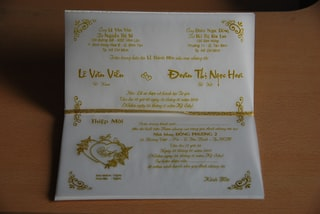

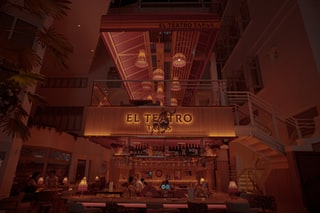

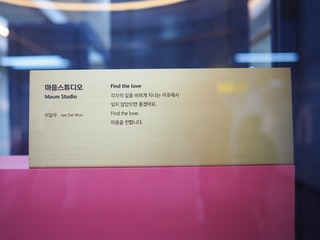

In [11]:
for image in image_finder.search_unsplash('It is shown on the picture  Hello  I have a reservation , under the name Lee , Leo Lee .', results_count=3):
    image.show()

In [24]:
mmchat = load_dataset("silver/mmchat")

No config specified, defaulting to: mmchat/mmchat
Reusing dataset mmchat (/home/admin/.cache/huggingface/datasets/silver___mmchat/mmchat/1.0.0/9f3d21697d61975eb26fcd64c314ea0bb3291e778f38c1e9318570b60279b00b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
mmchat['train'][1]

{'dialog': ['你只拍出了你十分之一的美', '你的头像竟然换了，奥'],
 'weibo_content': '分享图片',
 'imgs': ['https://wx4.sinaimg.cn/mw2048/d716a6e2ly1fmug2w2l9qj21o02yox6p.jpg']}

In [26]:
from parlai.core.image_featurizers import ImageLoader

In [29]:
imageloader = ImageLoader('faster_r_cnn_152_32x8d')._init_faster_r_cnn()

AttributeError: 'str' object has no attribute 'copy'

In [9]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
import torch

In [3]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

In [6]:
faterrcnn = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /home/admin/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100.0%


In [13]:
faterrcnn.eval()
x = torch.rand(1, 3, 300, 400)
predictions = faterrcnn(x)

In [11]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [14]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork


# To assist you in designing the feature extractor you may want to print out
# the available nodes for resnet50.
m = resnet50()
train_nodes, eval_nodes = get_graph_node_names(resnet50())

In [15]:
train_nodes

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.relu_1',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.add',
 'layer1.0.relu_2',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.relu_1',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.relu_2',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.relu',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.relu_1',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.add',
 'layer1.2.relu_2',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.relu_1',
 'layer2.0.conv3',
 'layer2.0.bn3',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_2',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.1.relu_1',
 'layer2.

In [ ]:
return_nodes = {'avgpool': 'avgpool', 'flatten': 'flatten', 'fc': 'fc'}
create_feature_extractor(m, return_nodes=return_nodes)

In [11]:
import json
for i in range(20):
    with open(f"/home/admin/multimodalchat/photochat/train/train_{str(i).zfill(2)}.json") as file:
        data = json.load(file)
        for d in data:
            print(d)
            break


{'dialogue': [{'message': 'whats up', 'share_photo': False, 'user_id': 1}, {'message': 'i am with friends', 'share_photo': False, 'user_id': 0}, {'message': 'thats cool', 'share_photo': False, 'user_id': 1}, {'message': 'just small gettogether', 'share_photo': False, 'user_id': 0}, {'message': 'yeah', 'share_photo': False, 'user_id': 0}, {'message': 'yeah', 'share_photo': False, 'user_id': 1}, {'message': '', 'share_photo': True, 'user_id': 0}, {'message': 'nice', 'share_photo': False, 'user_id': 1}], 'dialogue_id': 0, 'photo_description': 'Objects in the photo: Clothing, Woman, Drink, Man', 'photo_url': 'https://farm6.staticflickr.com/3789/8804001147_d92eb75fff_o.jpg', 'photo_id': 'train/2a5e821999a72c05'}
{'dialogue': [{'message': 'Hey there, how has your day been?', 'share_photo': False, 'user_id': 0}, {'message': 'Going Well', 'share_photo': False, 'user_id': 1}, {'message': 'Great to hear, I saw some of the new photos you took on facebook, the camera one looks great!', 'share_phot